# Integration of single-cell datasets reveals novel transcriptomic signatures of β-cells in human type 2 diabetes

#### Emanuele Bosi, Lorella Marselli, Carmela De Luca, Mara Suleiman, Marta Tesi, Mark Ibberson, Decio L. Eizirik, Miriam Cnop and Piero Marchetti

The present notebook embeds (most of) the analyses performed in our work, that is the re-analysis and integration of different datasets of human islets single-cell transcriptomes from diabetic and non-diabetic donors.

The first step of our workflow is to generate [annotated data matrices](https://icb-anndata.readthedocs-hosted.com/en/stable/anndata.AnnData.html) by combining, for each dataset, three items:
* a read-count table, reporting the number of reads mapping on each gene for each cell. We obtained this file by re-analysing published raw data and combining the outputs obtained for each cell.
* a single-cell metadata file (.sdrf), reporting information associated to each cell (such as Diabetes status, BMI, etc.), that we downloaded from gene expression repositories. For XIN and LAW, the metadata source was SRA, for SEG it was ENA.
Note that, for LAW, additional files are required:
    1. Supplementary table 1 (lawlor_table_S1.tsv), reporting the correspondence between cells and patients
    2. A list of SRR IDs corresponding to single-cells that passed QC in the original study.
* an annotation file indicating mitochondrial genes (ensembl/mitochondrial_genes.txt), which can be found in the ensembl annotation.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import anndata as ad
import scipy
import matplotlib.pyplot as plt
import mnnpy

# the location of read-count tables and metadata files are indicated here  
count_files = ["input_files/%s" %f for f in ["SEG_counts.tsv","XIN_counts.tsv","LAW_counts.tsv"]]
metadata_files = ["input_files/%s" %f for f in ["SEG_metadata.sdrf","XIN_metadata.sdrf","LAW_metadata.sdrf"]]
mitochondrial_annotation = "input_files/ensembl/mitochondrial_genes.txt"

/usr/local/lib/python3.6/dist-packages/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/mnnpy/utils.py:14: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "l2_norm" failed type inference due to: Invalid use of Function(<function norm at 0x7f3b3c051ae8>) with argument(s) of type(s): (axis=Literal[int](1), x=array(float32, 2d, A))
 * parameterized
In definition 0:
    TypeError: norm_impl() got an unexpected keyword argument 'x'
    raised from /usr/local/lib/python3.6/dist-packages/numba/typing/templates.py:539
In definition 1:
    TypeError: norm_impl() got an unexpected keyword argument 'x'
    raised from /usr/local/lib/python3.6/dist-packages/numba/typing/templates.py:539
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: 

/usr/local/lib/python3.6/dist-packages/numba/object_mode_passes.py:178: NumbaWarning: Function "adjust_s_variance" was compiled in object mode without forceobj=True, but has lifted loops.

File "../../../../usr/local/lib/python3.6/dist-packages/mnnpy/utils.py", line 201:
def adjust_s_variance(data1, data2, curcell, curvect, sigma):
    distance1 = np.zeros((data1.shape[0], 2), dtype=np.float32)
    ^

  state.func_ir.loc))
/usr/local/lib/python3.6/dist-packages/numba/object_mode_passes.py:188: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "../../../../usr/local/lib/python3.6/dist-packages/mnnpy/utils.py", line 201:
def adjust_s_variance(data1, data2, curcell, curvect, sigma):
    distance1 = np.zeros((data1.shape[0],

#### Functions to parse input files
In the blocks below I define the functions used to parse the input files and generate Adata objects.
Since metadata files had different formats, I defined separate functions for each dataset.

In [2]:
# metadata parsing
# metadata 

# parse sra metadata 
def sampleName2Pnumber(sampleName,d):
    import re
    c = "C" + re.split("[_-]",sampleName)[0][:-2]
    return d.get(c,"NA")

def getMetadataSEG(sdrf,colsToUse=['Characteristics[individual]',
                                         'Comment[ENA_RUN]',
                                         'Characteristics[single cell well quality]',
                                         'Characteristics[cell type]',
                                         'Characteristics[disease]',
                                         'Characteristics[sex]',
                                         'Characteristics[age]',
                                         'Characteristics[body mass index]'],
                         index_col='Comment[ENA_RUN]'):
    """ retrieve information associated with each cell from a sdrf file """
    return pd.read_table(sdrf,sep='\t',usecols=colsToUse,index_col=index_col,squeeze=True)

def getMetadataLAW(sra,s1="input_files/lawlor_table_S1.tsv",
                   srrList="input_files/lawlor_srrlist_only_scRNAseq.txt"):
    index_col = "Run"
    colsToUse = ["Patient Number","UNOS.ID","Status","BMI","Type (see Fig.1A)",
                 "Sequencing Batch","HbA1c"]
    colsToUse2 = ["Run","Age","health_state","race","sex","Sample Name"]
    # I used info from table S1 to get the below dict linking Cs to Patient numbers
    cs2ps = {'C1': 'P1','C10': 'P7','C11': 'P7','C12': 'P8','C13': 'P8','C2': 'P1',
 'C3': 'P1','C4': 'P6','C5': 'P2','C6': 'P3','C7': 'P3','C8': 'P4','C9': 'P5'}
    # here in `lawlor_srrlist_only_scRNAseq.txt` are the SRR ids of QC-passed cells
    with open(srrList) as fh: 
        toKeep = {l.strip() for l in fh}
    df1 = pd.read_table(s1,usecols=colsToUse)
    df1 = df1[df1["Type (see Fig.1A)"]=="Dissociated"]
    df2 = pd.read_csv(sra ,usecols=colsToUse2)
    df2["Patient Number"] = list(map(lambda x: sampleName2Pnumber(x,cs2ps),df2["Sample Name"]))
    df = pd.merge(df2,df1,on="Patient Number",suffixes=("","_x"))
    df = df[df["Run"].isin(toKeep)]
    return df

def getMetadataXIN(sra):
    colsToUse = ["Run","Age","cell_subtype","Condition","donor_id","Ethnicity","gender"]
    df = pd.read_csv(sra ,usecols=colsToUse)
    return df


metadataSEG = getMetadataSEG(metadata_files[0])
metadataXIN = getMetadataXIN(metadata_files[1])
metadataLAW = getMetadataLAW(metadata_files[2])

In [3]:
metadataXIN.head()

,Run,Age,cell_subtype,Condition,donor_id,Ethnicity,gender
0,SRR3541303,23,beta,non-diabetic,Non T2D 1,AA,male
1,SRR3541304,23,beta,non-diabetic,Non T2D 1,AA,male
2,SRR3541305,23,beta,non-diabetic,Non T2D 1,AA,male
3,SRR3541306,23,beta,non-diabetic,Non T2D 1,AA,male
4,SRR3541308,23,beta,non-diabetic,Non T2D 1,AA,male


In [4]:
def countTable2Adata(countTable,metadata,skipSTARInfos=False,toKeepOnlyIds=None,sep=" "):
    """ create a `Adata` object, from STAR count table and sdrf infos, computing all
    necessary QC metrics (number of genes, read counts, mitochondrial fraction).
    - countTable: count table obtained merging the output of STAR (with --quantMode GeneCounts)
                  obtained for each cell
    - metadata: dataframe with metadata information
    - skipSTARInfos: specify if first four lines (with additional info from STAR) should be skipped
    - toKeepOnlyIds: file with cell IDs that should be kept (the others will be excluded)
    - sep: character used to separate fields
    """
    count_df = pd.read_table(countTable,index_col=0,header=0,engine="python",sep=sep)
    ## get X (value matrix)
    if skipSTARInfos: X = count_df.T.apply(pd.to_numeric)
    else: X = count_df.iloc[4:,:].T.apply(pd.to_numeric)
    if toKeepOnlyIds != None:
        with open(toKeepOnlyIds) as fh:
            toKeepOnlyIds_ = {l.strip() for l in fh}
        X = X[X.index.isin(toKeepOnlyIds_)]
    ## get obs df
    obs_idxs = count_df.columns
    obs = metadata
    if "Characteristics[individual]" in obs.columns:
        obs.columns = map(lambda x: x.replace("Characteristics[","").replace("]",""),
                          obs.columns.values)
    obs.index.name = None
    obs.reindex(obs_idxs)
    # add STAR infos
    if not skipSTARInfos:
        for r in ["N_unmapped","N_multimapping","N_noFeature","N_ambiguous"]:
            obs[r] = count_df.loc[r,]
    X.index = obs.index
    # get var df
    if skipSTARInfos: var = pd.DataFrame(index=count_df.index)
    else: var = pd.DataFrame(index=count_df.index[4:])
    # make adata and add mapping QC infos
    adata = ad.AnnData(X,obs=obs,var=var)
    return adata

ad_seg = countTable2Adata(count_files[0],metadataSEG)
ad_xin = countTable2Adata(count_files[1],metadataXIN,
                          skipSTARInfos=True,sep="\t")
ad_law = countTable2Adata(count_files[2],metadataLAW,
                          skipSTARInfos=True,sep="\t",
                          toKeepOnlyIds="input_files/lawlor_srrlist_only_scRNAseq.txt")


Transforming to str index.
Transforming to str index.


After importing the datasets, low quality cells need to be removed. The variables used to flag cells to be removed are:
    - total read counts. High values are usually associated to doublets.
    - number of expressed genes. Doublets also have usually higher number of genes expressed.
    - fraction of reads mapped to mitochondrial genes. When a cell is lysed, cellular mRNA gets degraded, while mitochondrial RNA is more protected. Hence, cells with high mitochondrial fraction should be excluded.

... storing 'individual' as categorical
... storing 'single cell well quality' as categorical
... storing 'cell type' as categorical
... storing 'disease' as categorical
... storing 'sex' as categorical
... storing 'cell_subtype' as categorical
... storing 'Condition' as categorical
... storing 'donor_id' as categorical
... storing 'Ethnicity' as categorical
... storing 'gender' as categorical
... storing 'health_state' as categorical
... storing 'race' as categorical
... storing 'sex' as categorical
... storing 'Patient Number' as categorical
... storing 'UNOS.ID' as categorical
... storing 'Status' as categorical
... storing 'Type (see Fig.1A)' as categorical


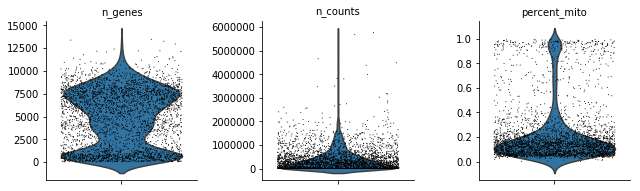

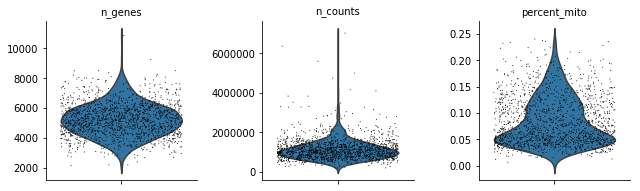

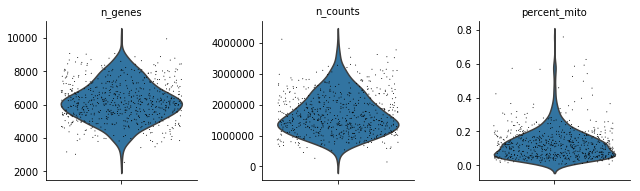

In [5]:
def get_n_genes(adata):
    """ return number of genes with at least 1 mapping read """
    return (adata.X>0).sum(axis=1)

def get_n_counts(adata,genes_subset=None):
    """ return number of reads mapped to genes """
    if genes_subset == None: return np.sum(adata.X,axis=1)
    return np.sum(adata[:,genes_subset].X,axis=1)

def get_percent_mito(adata,mitochondrial_genes=None):
    """ return fraction of reads mapped to mitochondrial genes """
    if mitochondrial_genes == None: 
        mitochondrial_genes = [i.strip()
                               for i in open("input_files/ensembl/mitochondrial_genes.txt")]
    mito_count,all_count = get_n_counts(adata,mitochondrial_genes),get_n_counts(adata)
    return mito_count/all_count

def addQC2Adata(adata):
    """ compute the following QC metrics and add them to `adata`:
        - number of genes
        - total read count
        - fraction of reads mapping on mitochondrial genes """

    n_genes,n_counts,percent_mito = map(lambda x: x(adata),
                                        [get_n_genes,get_n_counts,get_percent_mito])
    for label,value in zip(("n_genes","n_counts","percent_mito"),
                           (n_genes,n_counts,percent_mito)):
        adata.obs[label] = value

for adata in [ad_seg,ad_xin,ad_law]:
    addQC2Adata(adata)
    sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],jitter=0.4,multi_panel=True,show=False)

Plots are ordered as follows: SEG, XIN, LAW.

In these violinplots we kept low-quality cells indicated in SEG metadata (field name:"single cell well quality").
Plots below are reported without these cells.

Trying to set attribute `.var` of view, making a copy.


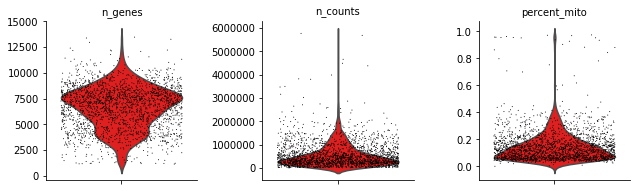

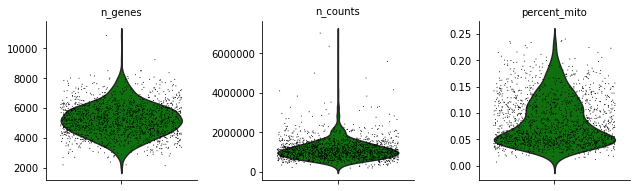

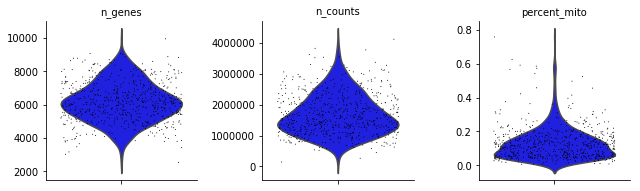

In [6]:
def getOKdata(adata,min_cells=3):
    """ SEG metadata has indicate with `OK` cells with high quality """
    oks = adata[adata.obs["single cell well quality"]=="OK",]
    sc.pp.filter_genes(oks, min_cells=min_cells)
    return oks

ad_seg = getOKdata(ad_seg)
for adata,col in zip([ad_seg,ad_xin,ad_law],["red","green","blue"]):
    sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
                 jitter=0.4,multi_panel=True,color=col)

Although univariate distributions are informative,
for QC it's more useful to plot the variables together to observe of how they covariate.

In [7]:
#sc.pl.scatter(ad_law, 'n_counts', 'n_genes', color='percent_mito')
def addNullPoint(ad):
    """ add a null point with mit. fraction = 1 to uniform scales across dataframes """
    return ad.obs.append({'percent_mito' : 1,'n_counts':0, 'n_genes':0},
                         ignore_index=True)

def jointPlot(ad,xlim=None,ylim=None,hist_col=None,magnitude="K",palette="viridis",title=""):
    df = addNullPoint(ad)
    if xlim!=None: df = df[df['n_counts']<xlim]
    df = df[df['percent_mito']<=1]
    grid = sns.JointGrid(x='n_counts', y='n_genes', data=df)
    g = grid.plot_joint(sns.scatterplot, hue='percent_mito', data=df,palette=palette, linewidth=0,alpha=0.8)
    ax_x = sns.distplot(df['n_counts'], ax=g.ax_marg_x,color=hist_col)
    ax_y = sns.distplot(df['n_genes'], ax=g.ax_marg_y, vertical=True,color=hist_col)
    ax_x.set(xlabel='', ylabel='')
    ax_y.set(xlabel='', ylabel='')
    g.set_axis_labels(xlabel='Read counts',ylabel='Number of genes')
    if xlim==None: g.ax_marg_x.set_xlim(0,g.ax_marg_x.get_xlim()[1])
    else: g.ax_marg_x.set_xlim(0,xlim)
    #g.ax_marg_x.set_xlim(0,150000)
    if ylim==None: g.ax_marg_y.set_ylim(0,g.ax_marg_y.get_ylim()[1])
    else: g.ax_marg_y.set_ylim(0,ylim)
    #g.ax_marg_y.set_ylim(0,10000)
    if magnitude == "K": mag_n = 1000.
    else: mag_n = 1000000.
    xlabels = ['{:.1f}'.format(x) + magnitude for x in g.ax_joint.get_xticks()/mag_n]
    g.ax_joint.set_xticklabels(xlabels)
    new_labels = ["0-0.25","0.25-0.50","0.50-0.75","0.75-1"]
    handles, labels = g.ax_joint.get_legend_handles_labels()
    g.ax_joint.legend(handles=handles[1:], labels=new_labels,title="Mit. fraction")
    g.fig.suptitle(title)
    #print(legend.texts)
    #leg.texts
    return g

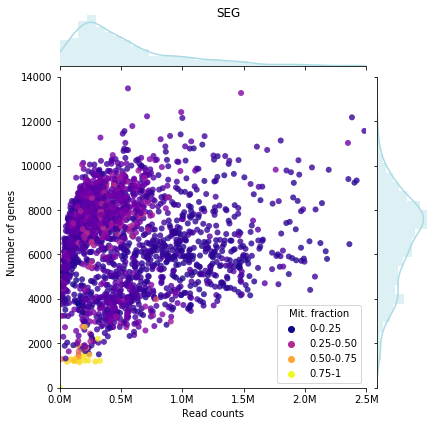

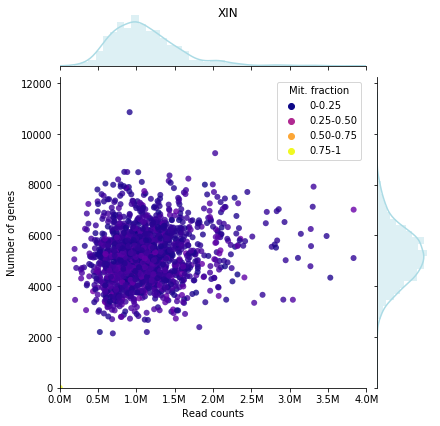

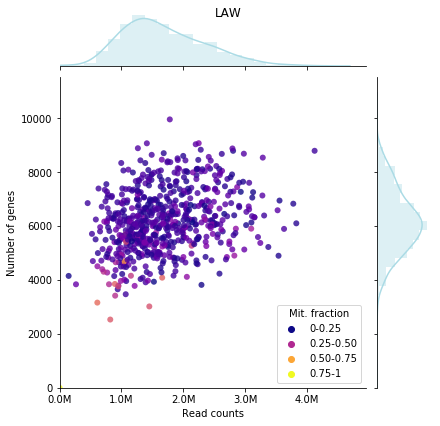

In [8]:
g1 = jointPlot(ad_seg,magnitude="M",title="SEG",
               xlim=2500000,ylim=14000,
               hist_col="#ABDBE5",palette="plasma")
plt.savefig("plots/jointPlot.SEG.pdf", transparent=True)

g2 = jointPlot(ad_xin,magnitude="M",palette="plasma",
               xlim=4000000,title="XIN",
               hist_col="#ABDBE5")
plt.savefig("plots/jointPlot.XIN.pdf", transparent=True)

g3 = jointPlot(ad_law,magnitude="M",palette="plasma",
               title="LAW",
               hist_col="#ABDBE5")
plt.savefig("plots/jointPlot.LAW.pdf", transparent=True)

In [9]:
def filterData(adata,
               min_genes=3000,
               max_genes=10000,
               min_counts=100000,
               max_counts=1000000,
               mito_fract=0.2,
               min_cells=3,
               report=False):
    """ filter data basing on QC thresholds """
    filtered = adata[(adata.obs["percent_mito"]<=mito_fract),]
    for k,v in {"min_genes":min_genes,  "max_genes":max_genes,
                "min_counts":min_counts, "max_counts":max_counts}.items():
        kwargs = {k:v}
    
        sc.pp.filter_cells(filtered,**kwargs)
    sc.pp.filter_genes(filtered, min_cells=min_cells)
    if report:
        before = adata.obs["single cell well quality"].value_counts()
        print("""
        before filtering: 
                - %s cells (%s OK, %s low quality, %s others)
                - %s genes""" %(getCountReport(adata))) 
        print("""
        after filtering:
                - %s cells (%s OK, %s low quality, %s others)
                - %s genes""" %(getCountReport(filtered)))
    return filtered

# apply chosen filters
ad_seg_filt = filterData(ad_seg,
               min_genes=2500,
               max_genes=9000,
               min_counts=300000,
               max_counts=2000000,
               mito_fract=0.4)
ad_xin_filt = filterData(ad_xin,
               min_genes=2500,
               max_genes=7000,
               min_counts=500000,
               max_counts=2200000)
ad_law_filt = filterData(ad_law,
               min_genes=2500,
               max_genes=9000,
               min_counts=1000000,
               max_counts=3000000,
               mito_fract=0.4)

Trying to set attribute `.obs` of view, making a copy.
Trying to set attribute `.obs` of view, making a copy.
Trying to set attribute `.obs` of view, making a copy.


Although the cells are mostly good, we used ad-hoc filters to exclude extreme values and have more reliable cells for downstream analyses. The violinplots below report the univariate distributions after filtering out low-quality cells.

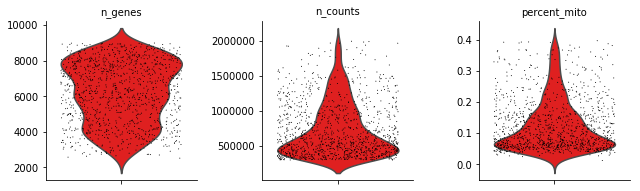

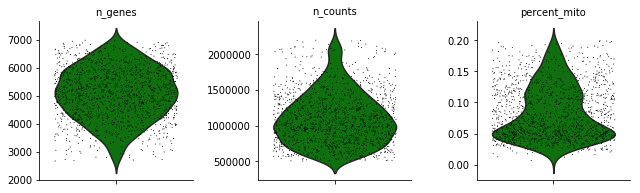

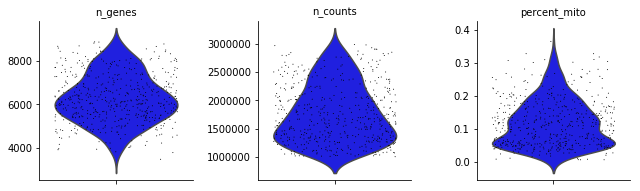

In [10]:
filtered_ads = [ad_seg_filt,ad_xin_filt,ad_law_filt]
colors = ["red","green","blue"]
for adata,col in zip(filtered_ads,colors):
    sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
                 jitter=0.4,multi_panel=True,color=col)

In [11]:
filtered_genes = []
for ad_ in filtered_ads:
    filtered_genes.append(set(ad_.var.index))

Downstream methods require the presence of same genes in the datasets, therefore we excluded genes present only in a dataset and not in others (n=5092), of which 2469, 1651 and 972 are exclusively present in SEG, XIN and LAW, respectively.

To assess the impact of their removal, we counted the number of cells affected by it (i.e. the cells expressing these genes). The histogram below reports the distribution of the number of cells expressing genes to be removed. The vast majority of these genes are expressed in a low number of cells, meaning that their removal has a low impact.

After removing these genes, the three datasets are merged in a single dataframe.

Text(0.5, 1.0, 'Distribution of `Number of cells` in which the genes to-be-removed are expressed')

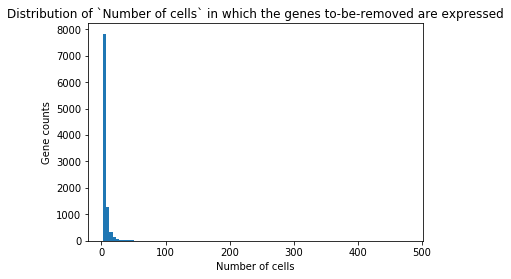

In [12]:
further_filtering = {}
shared = set.intersection(*filtered_genes)
for i,s in enumerate(filtered_genes):
    #others = filtered_genes[:i] + filtered_genes[i+1:]
    uniq = s.difference(shared)
    #missing_in_others = s.difference(*others)
    further_filtering.update(filtered_ads[i].var["n_cells"][list(uniq)].to_dict())
plt.hist(further_filtering.values(),bins=100)
plt.xlabel('Number of cells')
plt.ylabel('Gene counts')
plt.title('Distribution of `Number of cells` in which the genes to-be-removed are expressed')

In [13]:
# remove genes present only in one dataset
ad_seg_final = ad_seg_filt[:,~ad_seg_filt.var.index.isin(further_filtering)]
ad_xin_final = ad_xin_filt[:,~ad_xin_filt.var.index.isin(further_filtering)]
ad_law_final = ad_law_filt[:,~ad_law_filt.var.index.isin(further_filtering)]
ads_final = [ad_seg_final,ad_xin_final,ad_law_final]

for dsname,ad_ in zip(["SEG","XIN","LAW"],ads_final):
    ad_.obs['dataset'] = [dsname]*ad_.n_obs
adata_final = ads_final[0].concatenate(ads_final[1:])

Trying to set attribute `.obs` of view, making a copy.
Trying to set attribute `.obs` of view, making a copy.
Trying to set attribute `.obs` of view, making a copy.


### Dataset integration with MNN
Matching **M**utual **N**earest **N**eighbors (*MNN*) is a statistical technique used to minimize technical differences in gene expression due to different experiments (aka *dataset integration*). Here we apply such approach to minimize technical differences between the 3 datasets used and to infer populations structure and differentially-expressed genes.

The workflow we will be using for our analysis is the following:

- Identification of Highly Variable Genes (*HVGs*)
- Dataset integration with MNN
- Unsupervised clustering of cells and identification of $\beta$-cells 
- Identification of T2D differentially expressed genes (DEGs) in $\beta$-cells

#### Identification of Highly Variable Genes (HGVs)
Some mathematical analyses (such as UMAP) greatly benefit from before-hand feature selection to remove computational burden and noise sources. Therefore, it is a common procedure to select a set (in the range of 0.5-5k) of Highly Variable Genes (HVGs). 

For our specific case, MNN authors recommend to apply their methods on a selection of HVGs. I will be using the method implemented in scanpy ([highly_variable_genes](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/scanpy.pp.highly_variable_genes.html#scanpy.pp.highly_variable_genes)) to perform such task, which will add a True/False flag to the genes to indicate if they are in the top *z* variable genes. Note that here we aim at finding the top **shared** 1k variable genes. The *highly_variable_genes* method allows to pass a key indicating the batch factor, which I will be using to indicating the dataset origin. With this option, the method will add to the *adata.var* dataframe a boolean flag indicating if a given gene is a HVG for all the datasets (column name is *highly_variable_intersection*).

Therefore a higher *n_top_genes* (3'500) has been used in order to achieve a HVGs intersection of 971 genes.

In [14]:
adata_pp = adata_final.copy()
# standardize and log-transform data
# standardize counts to 10k per cell
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e4)
# Log transform data
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)

In [15]:
adata_final = adata_pp # restore adata to its backup
sc.pp.highly_variable_genes(adata_final,n_top_genes=3500,batch_key="dataset")

... storing 'Condition' as categorical
... storing 'Ethnicity' as categorical
... storing 'Patient Number' as categorical
... storing 'Run' as categorical
... storing 'Sample Name' as categorical
... storing 'Status' as categorical
... storing 'Type (see Fig.1A)' as categorical
... storing 'UNOS.ID' as categorical
... storing 'cell type' as categorical
... storing 'cell_subtype' as categorical
... storing 'dataset' as categorical
... storing 'disease' as categorical
... storing 'donor_id' as categorical
... storing 'gender' as categorical
... storing 'health_state' as categorical
... storing 'individual' as categorical
... storing 'race' as categorical
... storing 'sex' as categorical
... storing 'single cell well quality' as categorical


In [16]:
adata_final.var[adata_final.var["highly_variable"]]
sum(adata_final.var["highly_variable_intersection"])
hvgs = adata_final.var[adata_final.var["highly_variable_intersection"]].index.values

In [17]:
spliced = [adata_final[adata_final.obs["dataset"]==x,:].copy() for x in ["LAW","SEG","XIN"]]
spliced[0]

AnnData object with n_obs × n_vars = 516 × 27931 
    obs: 'Age', 'BMI', 'Condition', 'Ethnicity', 'HbA1c', 'N_ambiguous', 'N_multimapping', 'N_noFeature', 'N_unmapped', 'Patient Number', 'Run', 'Sample Name', 'Sequencing Batch', 'Status', 'Type (see Fig.1A)', 'UNOS.ID', 'age', 'batch', 'body mass index', 'cell type', 'cell_subtype', 'dataset', 'disease', 'donor_id', 'gender', 'health_state', 'individual', 'n_counts', 'n_genes', 'percent_mito', 'race', 'sex', 'single cell well quality'
    var: 'n_cells-0', 'n_cells-1', 'n_cells-2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

### MNN correction
After HVGs, MNN correction is computed and plotted before/after correction, with cells color labelled according to dataset of origin.

In [18]:
import mnnpy
mnn_corrected = mnnpy.mnn_correct(*spliced, 
                              var_subset=hvgs, 
                              batch_categories = ["LAW","SEG","XIN"])

Performing cosine normalization...


/usr/local/lib/python3.6/dist-packages/mnnpy/utils.py:14: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "l2_norm" failed type inference due to: Invalid use of Function(<function norm at 0x7f3b3c051ae8>) with argument(s) of type(s): (axis=Literal[int](1), x=array(float32, 2d, A))
 * parameterized
In definition 0:
    TypeError: norm_impl() got an unexpected keyword argument 'x'
    raised from /usr/local/lib/python3.6/dist-packages/numba/typing/templates.py:539
In definition 1:
    TypeError: norm_impl() got an unexpected keyword argument 'x'
    raised from /usr/local/lib/python3.6/dist-packages/numba/typing/templates.py:539
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<function norm at 0x7f3b3c051ae8>)
[2] During: typing of call at /usr/local/lib/python3.6/dist-packages/mnnpy/utils.py (16)


File "../../../../usr/local/lib/python

Starting MNN correct iteration. Reference batch: 0
Step 1 of 2: processing batch 1
  Looking for MNNs...


/usr/local/lib/python3.6/dist-packages/mnnpy/utils.py:88: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "find_mutual_nn" failed type inference due to: non-precise type pyobject
[1] During: typing of argument at /usr/local/lib/python3.6/dist-packages/mnnpy/utils.py (94)

File "../../../../usr/local/lib/python3.6/dist-packages/mnnpy/utils.py", line 94:
def find_mutual_nn(data1, data2, k1, k2, n_jobs):
    <source elided>
    mutual_2 = []
    for index_2 in range(data2.shape[0]):
    ^

  @jit((float32[:, :], float32[:, :], int8, int8, int8))
/usr/local/lib/python3.6/dist-packages/numba/object_mode_passes.py:178: NumbaWarning: Function "find_mutual_nn" was compiled in object mode without forceobj=True.

File "../../../../usr/local/lib/python3.6/dist-packages/mnnpy/utils.py", line 94:
def find_mutual_nn(data1, data2, k1, k2, n_jobs):
    <source elided>
    mutual_2 = []
    for index_2 in range(data2.shape[0]):
    ^

  state.func_

  Computing correction vectors...


/usr/local/lib/python3.6/dist-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'mnn2' of function 'compute_correction'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../usr/local/lib/python3.6/dist-packages/mnnpy/utils.py", line 107:
def compute_correction(data1, data2, mnn1, mnn2, data2_or_raw2, sigma):
    <source elided>
    vect_reduced = np.zeros((data2.shape[0], vect.shape[1]), dtype=np.float32)
    for index, ve in zip(mnn2, vect):
    ^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/usr/local/lib/python3.6/dist-packages/mnnpy/utils.py:102: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function compute_correction failed at nopython mode lowering due to: iterating over 2D array

Fil

  Adjusting variance...
  Applying correction...
Step 2 of 2: processing batch 2
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
MNN correction complete. Gathering output...
Packing AnnData object...
Done.


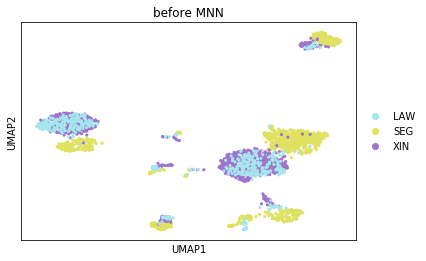

... storing 'Condition' as categorical
... storing 'Ethnicity' as categorical
... storing 'Patient Number' as categorical
... storing 'Run' as categorical
... storing 'Sample Name' as categorical
... storing 'Status' as categorical
... storing 'Type (see Fig.1A)' as categorical
... storing 'UNOS.ID' as categorical
... storing 'cell type' as categorical
... storing 'cell_subtype' as categorical
... storing 'dataset' as categorical
... storing 'disease' as categorical
... storing 'donor_id' as categorical
... storing 'gender' as categorical
... storing 'health_state' as categorical
... storing 'individual' as categorical
... storing 'race' as categorical
... storing 'sex' as categorical
... storing 'single cell well quality' as categorical


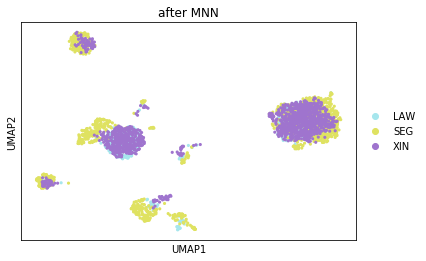

In [19]:
# before/after MNN visualization
sc.pp.pca(adata_final)
sc.pp.neighbors(adata_final)
sc.tl.umap(adata_final)

if type(mnn_corrected) == tuple: mnn_corrected = mnn_corrected[0]
sc.pp.pca(mnn_corrected)
sc.pp.neighbors(mnn_corrected)
sc.tl.umap(mnn_corrected)

sc.pl.umap(adata_final, color='dataset',palette=['#A6E6ED','#DFE261','#9F74CE'],title="before MNN")
sc.pl.umap(mnn_corrected, color='dataset',palette=['#A6E6ED','#DFE261','#9F74CE'],title="after MNN")

### Unsupervised clustering and identification of marker genes
To detect cell types we applied the unsupervise clustering method louvain implemented in scanpy ([louvain](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/scanpy.tl.louvain.html#scanpy.tl.louvain)). Unsupervised clustering will be done irrespective of dataset of origin.

In [20]:
sc.tl.louvain(mnn_corrected,resolution=0.5)

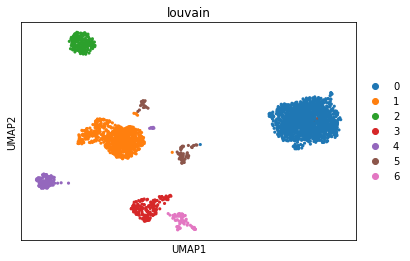

In [21]:
fig,ax = plt.subplots()
sc.pl.umap(mnn_corrected, color='louvain',ax=ax,show=False)
plt.show()

### Identification of marker genes
Before looking at which genes significantly contribute to differentiating cell clusters, we imported gene symbols to our dataset using the ensembl annotation.


In [22]:
from BCBio import GFF

ens_container = {}

in_file = "input_files/ensembl/Homo_sapiens.GRCh37.87.chr_patch_hapl_scaff.gtf"

in_handle = open(in_file)
for rec in GFF.parse(in_handle):
    for f in rec.features:
        if "gene_id" not in f.qualifiers: continue
        # if len(set(f.qualifiers["gene_id"]).intersection(degs_ens_set))==0: continue
        gene_ids = f.qualifiers["gene_id"]
        for gene_id in gene_ids: ens_container[gene_id] = f.qualifiers
in_handle.close()


In [23]:
ens_container['ENSG00000223972']

{'gene_id': ['ENSG00000223972'],
 'gene_version': ['4'],
 'gene_name': ['DDX11L1'],
 'gene_source': ['ensembl_havana'],
 'gene_biotype': ['pseudogene'],
 'source': ['ensembl_havana']}

In [24]:
# add gene name and biotype to mnn_corrected
mnn_corrected.var["gene_name"] = mnn_corrected.var.index.map(lambda x: ens_container[x]['gene_name'][0])
mnn_corrected.var["gene_biotype"] = mnn_corrected.var.index.map(lambda x: ens_container[x]['gene_biotype'][0])


In [25]:
mnn_corrected.var.head()

,n_cells-0,n_cells-1,n_cells-2,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection,gene_name,gene_biotype
ENSG00000227232,75,37,28,False,0.001347,-2.825516,-1.226334,0,False,WASH7P,pseudogene
ENSG00000237683,70,106,71,False,0.006300,-1.890436,-0.697738,0,False,AL627309.1,protein_coding
ENSG00000241860,21,88,47,False,0.002078,-2.709718,-1.166846,0,False,RP11-34P13.13,processed_transcript
ENSG00000241599,9,16,5,False,0.000380,-2.565999,-1.102470,0,False,RP11-34P13.9,lincRNA
ENSG00000228463,22,38,21,False,0.003111,-1.645200,-0.548021,0,False,AP006222.2,lincRNA


In [26]:
sc.tl.rank_genes_groups(mnn_corrected, groupby='louvain', key_added='rank_genes')

... storing 'gene_name' as categorical
... storing 'gene_biotype' as categorical
/usr/local/lib/python3.6/dist-packages/scanpy/tools/_rank_genes_groups.py:223: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


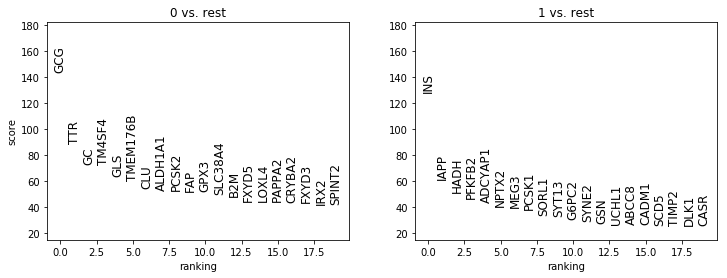

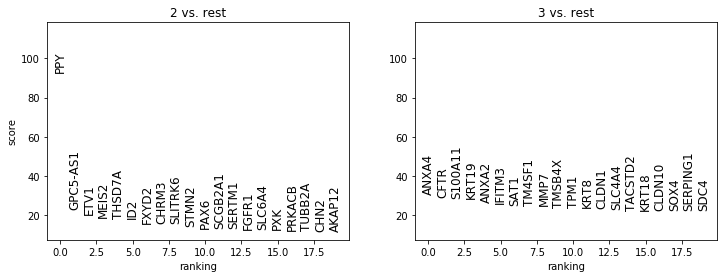

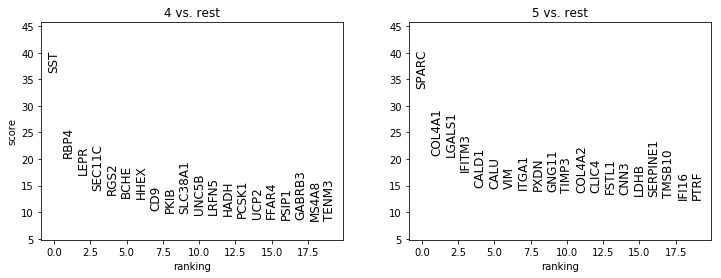

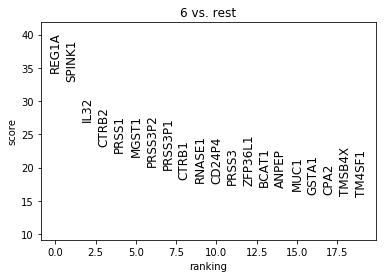

In [27]:
#Plot marker genes
sc.pl.rank_genes_groups(mnn_corrected, key='rank_genes', groups=['0','1'], fontsize=12,gene_symbols="gene_name")
# 0 -> alpha; 1 -> beta
sc.pl.rank_genes_groups(mnn_corrected, key='rank_genes', groups=['2','3',], fontsize=12,gene_symbols="gene_name")
# 2 -> gamma; 3 -> ductal
sc.pl.rank_genes_groups(mnn_corrected, key='rank_genes', groups=['4','5'], fontsize=12,gene_symbols="gene_name")
# 4 -> delta ; 5 -> stellate
sc.pl.rank_genes_groups(mnn_corrected, key='rank_genes', groups=['6'], fontsize=12,gene_symbols="gene_name")
# 6 -> acinar

Looking at the genes having expression significantly enriched in the cell groups it's possible to assess the pancreatic cell types basing on known marker genes.

Besides literature, the association between these genes and the proposed cell types can be verified on [PanglaoDB](https://panglaodb.se).
For instance the expression of SPARC in stellate cells can be found [here](https://panglaodb.se/search.html?query=%22SPARC%22&species=3&tumor=0&nonadult=0).

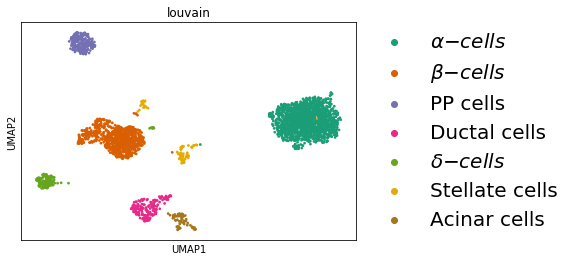

In [28]:
palette = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d']
fig, ax = plt.subplots(1,1)
mnn_corrected.rename_categories('louvain',[r'$\alpha{-}cells$', r'$\beta{-}cells$','PP cells','Ductal cells',
                                           r'$\delta{-}cells$','Stellate cells','Acinar cells'])
sc.pl.umap(mnn_corrected, color='louvain', size=30, legend_fontsize=20,ax=ax,palette=palette)
fig.savefig("plots/cell_types.pdf", bbox_inches='tight')

To highlight differences between cell types, we looked at the expression of the principal marker genes

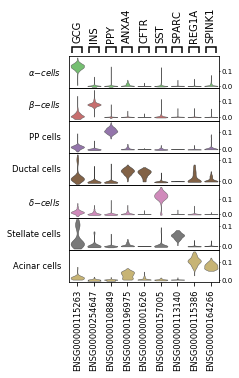

In [29]:
# we chose the most important marker genes to have some comp
marker_genes = {'GCG': 'ENSG00000115263',
                 'INS': 'ENSG00000254647',
                 'PPY': 'ENSG00000108849',
                 'ANXA4': 'ENSG00000196975',
                 'CFTR': 'ENSG00000001626',
                 'SST': 'ENSG00000157005',
                 'SPARC': 'ENSG00000113140',
                 'REG1A': 'ENSG00000115386',
                 'SPINK1': 'ENSG00000164266'}

sc.settings.figdir = 'plots/'
stacked_violins = sc.pl.stacked_violin(mnn_corrected, marker_genes,groupby='louvain',
                                       save="_marker_genes.pdf")

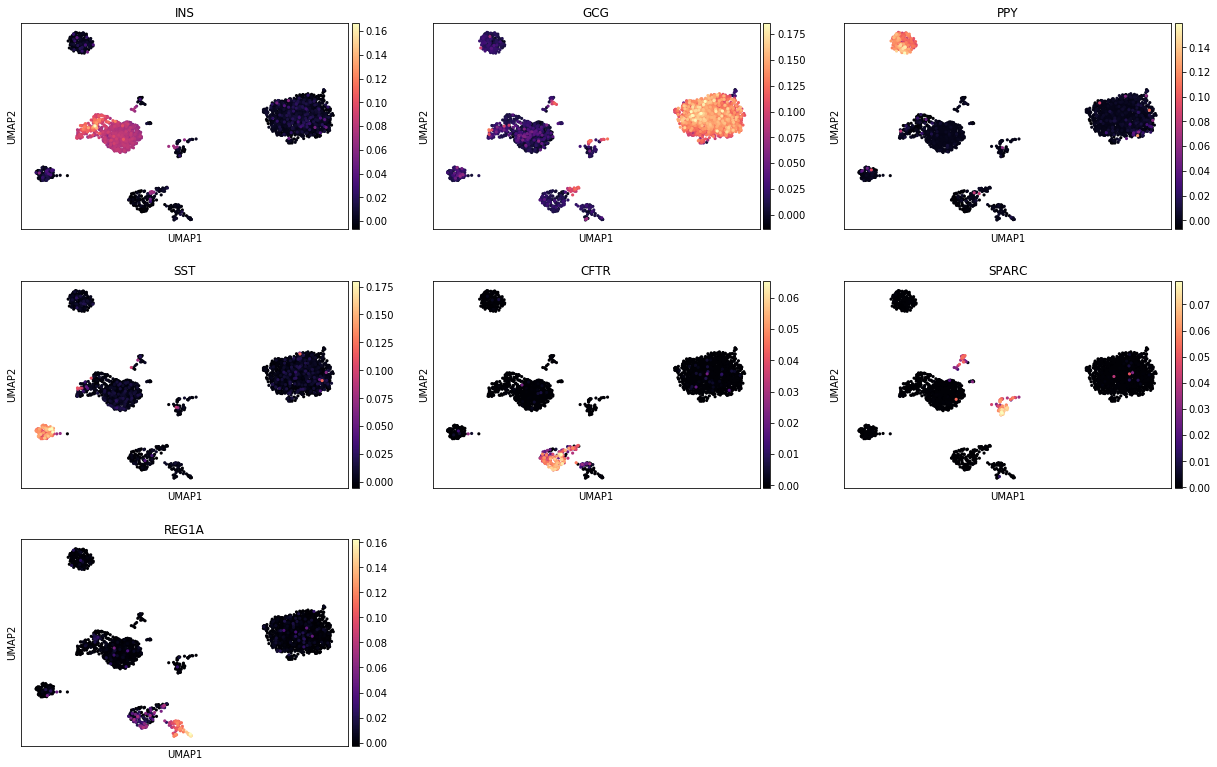

In [30]:
sc.pl.umap(mnn_corrected,color=['INS','GCG','PPY','SST','CFTR','SPARC','REG1A'],
           gene_symbols="gene_name",ncols=3,save="expression_map.pdf",cmap="magma")

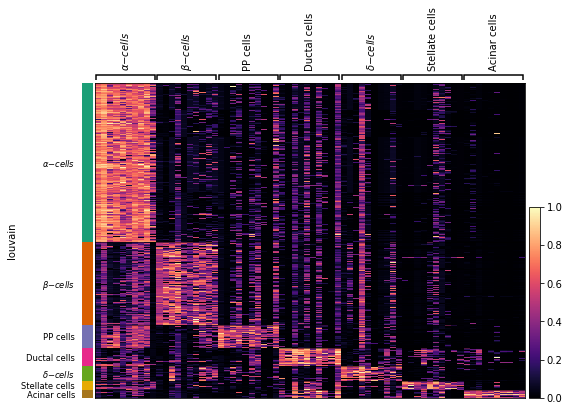

In [31]:
mnn_corrected.obs['louvain'].cat.reorder_categories([r'$\alpha{-}cells$', r'$\beta{-}cells$','PP cells','Ductal cells',
                                                     r'$\delta{-}cells$','Stellate cells','Acinar cells'],inplace=True)
sc.pl.rank_genes_groups_heatmap(mnn_corrected,n_genes=10,key="rank_genes",
                                groupby='louvain',dendrogram=False,standard_scale='var',
                                cmap="magma",save="heatmap_markers.pdf")

We also assessed cell type composition differences between datasets, and between T2D vs ND.

In [32]:
# since T2D and ND are indicated differently in the 3 metadata, terms are harmonised
mnn_corrected.obs["Condition"].replace({"non-diabetic":"ND"},inplace=True)
mnn_corrected.obs["disease"].replace({"type II diabetes mellitus":"T2D","normal":"ND"},inplace=True)

# then a dataframe storing cell type abundance in different datasets and conditions is built
conditions = mnn_corrected.obs.loc[:,["Condition","disease","Status"]].apply(
    lambda x: ','.join([x_ for x_ in x if x_!="nan"]), axis=1).values
datasets = mnn_corrected.obs["dataset"].values
cell_types = mnn_corrected.obs["louvain"].values

cell_type_df = pd.DataFrame({"cell_type":cell_types,
                       "dataset":datasets,
                       "condition":conditions})
# this is an intermediate dataframe
cell_type_df.head()

,cell_type,dataset,condition
0,$\alpha{-}cells$,LAW,T2D
1,Acinar cells,LAW,T2D
2,$\beta{-}cells$,LAW,T2D
3,Stellate cells,LAW,T2D
4,$\beta{-}cells$,LAW,T2D


In [33]:
# this is the final one
df_agg = cell_type_df.pivot_table(columns=['dataset','condition'],index='cell_type', aggfunc=len, fill_value=0)
df_agg

dataset           LAW      SEG       XIN     
condition          ND T2D   ND  T2D   ND  T2D
cell_type                                    
$\alpha{-}cells$  136  77  253  278  341  451
Acinar cells       12   7   33   21    0    0
$\beta{-}cells$   120  90  112   59  155  265
Stellate cells     16   8   24   12   15   15
Ductal cells       10  10   40   80   16   18
PP cells            7   7   51   96   26   43
$\delta{-}cells$   10   6   42   47   16   21

The table is very dense of information, allowing to test a number of hypotheses.
To represent all these factors and their combinations we used a donut plot.

The layers represent (from inner to outer)
    1. T2D (purple) vs ND (red) 
    2. Cell types (same color scheme as above plots)
    3. Datasets (same color scheme as above plots)
    4. T2D (purple) vs ND (red) *per dataset*


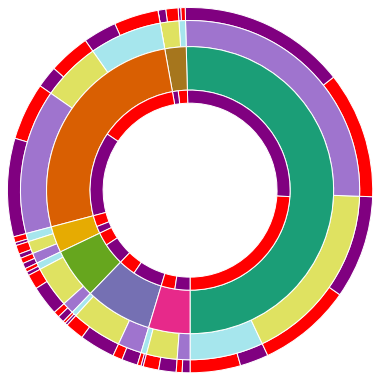

In [34]:
# prepare data for donuts
palettes_dict = dict(zip([r'$\alpha{-}cells$', r'$\beta{-}cells$','PP cells',r'$\delta{-}cells$','Ductal cells', 'Stellate cells','Acinar cells'] + \
                          ["LAW","SEG","XIN"] + ["ND","T2D"],
                         ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d'] \
                         + ['#A6E6ED','#DFE261','#9F74CE'] + ['red','purple']))

nested_groups,nested_labels = zip(*[
    # level 1: cell-types per t2dvsnd per dataset
    (df_agg.values.flatten(),list(df_agg.columns.get_level_values(1))*df_agg.shape[0]),
    # level 2: cell-types per dataset
    (df_agg.sum(level=0,axis=1).values.flatten(),list(df_agg.sum(level=0,axis=1).columns)*df_agg.shape[0]),
    # level 3: cell-types
    (df_agg.sum(axis=1),df_agg.sum(axis=1).index),
    # level 4: cell-types per t2dvsnd
    (df_agg.sum(level=1,axis=1).values.flatten(),list(df_agg.sum(level=1,axis=1).columns)*df_agg.shape[0])
])

def nestedDonuts(nested_groups,nested_labels,palettes_dict,widths=None,save_to=None,**piekwargs):
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots()
    if widths == None: widths = [0.3 for g in nested_groups]
    widths = pd.Series(widths)
    positions = 1 + widths[::-1].values.cumsum()[::-1]
    ax.axis('equal')
    for level,(groups,labels) in enumerate(zip(nested_groups,nested_labels)):
        explosions = [0. for i in groups]
        colors = [palettes_dict[i] for i in labels]
        radius,width = positions[level],widths[level]
        thePie, _ = ax.pie(groups,radius=radius,labels=None,colors=colors,startangle=-90.,explode=explosions,**piekwargs)
        plt.setp(thePie,width=width,edgecolor='white')
    plt.margins(0,0)
    plt.show()
    if save_to != None: fig.savefig(save_to, bbox_inches='tight')
nestedDonuts(nested_groups,nested_labels,palettes_dict,[0.15,0.3,0.5,0.15],save_to="plots/donut_cell_types.pdf")

### Differential expression analysis
Since DESeq2 runs on R we exported the beta-cell dataframe to be imported in R. Refer to the R code in the repository for more details. Note that DESeq2 requires raw read counts.

In [35]:
# get rows of beta cells
betaExtractor = mnn_corrected.obs["louvain"]=="$\\beta{-}cells$"

# extract variables for DE analysis
t2dCondition = mnn_corrected.obs.loc[betaExtractor,["Condition","disease","Status"]].apply(
    lambda x: ','.join([x_ for x_ in x if x_!="nan"]), axis=1).values
dataset = mnn_corrected.obs.loc[betaExtractor,"dataset"]
betaFactorDf = pd.DataFrame({'diabetes':t2dCondition,'dataset':dataset},
                            index=mnn_corrected.obs.loc[betaExtractor,:].index)
betaFactorDf.to_csv("diffExprAnalysis/beta_factors.csv")

In [36]:
# since DESeq2 wants raw counts I have to newly make adata
adata_counts = ads_final[0].concatenate(ads_final[1:])
betaReadCountDf = pd.DataFrame(data=adata_counts.X[betaExtractor,:],
                               index=mnn_corrected.obs.loc[betaExtractor,:].index,
                               columns=mnn_corrected.var.index.values)
betaReadCountDf.to_csv("diffExprAnalysis/beta_raw.csv")

Then data gets analysed in R 

### Gene set enrichment
Gene set enrichment has been done via web-server and results exported for visualization. The exported tables are present in the enrichr_out directory. Here I show handling of data to build a final table and plotting of most significant results.

In [37]:
import os,re
import pandas as pd

def dfMaker(tab,alias,direction):
    df = pd.read_table(tab)
    df["Direction"] = direction
    df["Dataset"] = alias
    pval_ = df["P-value"] >= 0.05
    return df


tables = ["BioPlanet_2019_table.txt",
"ENCODE_and_ChEA_Consensus_TFs_from_ChIP-X_table.txt",
"GO_Biological_Process_2018_table.txt",
"GO_Cellular_Component_2018_table.txt",
"GO_Molecular_Function_2018_table.txt",
"KEGG_2019_Human_table.txt",
"Reactome_2016_table.txt"]

aliases = ["BioPlanet","Encode/ChEA TFs","GO BP","GO CC","GO MF","KEGG","Reactome"]


dataframes = [dfMaker("enrichr_files/%s_%s" %(direction,tab),alias,direction)
                  for tab,alias in zip(tables,aliases)
                      for direction in ["up","down"]]
#        file_ = "degs_enrichr_up/%s_%s" %(direction,tab)
        
merged_dataframes = pd.concat(dataframes)
merged_dataframes.to_csv("Enrichr_results_merged.tsv")
merged_dataframes.head()

,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Direction,Dataset
0,Lysosome,3/121,0.003249,1.0,0,0,10.119750,57.979530,GGA1;AP3M1;SGSH,up,BioPlanet
1,"Fatty acid, triacylglycerol, and ketone body m...",3/173,0.008756,1.0,0,0,7.077976,33.535844,AGPAT5;MED13;CPT2,up,BioPlanet
2,Axonal growth stimulation,1/5,0.012191,1.0,0,0,81.632653,359.758308,ARHGDIA,up,BioPlanet
3,Import of palmitoyl-CoA into the mitochondrial...,1/8,0.019436,1.0,0,0,51.020408,201.052530,CPT2,up,BioPlanet
4,SREBP control of lipid biosynthesis,1/8,0.019436,1.0,0,0,51.020408,201.052530,SCAP,up,BioPlanet


In [38]:
# add KEGG to the kegg terms
keggs = merged_dataframes["Dataset"] == "KEGG"
merged_dataframes.loc[keggs,"Term"] = merged_dataframes.loc[keggs,"Term"] + " KEGG"

In [39]:
# get only relevant columns for plotting: Term, Overlap, P-value, Direction, Dataset
sig_pval = merged_dataframes["P-value"] <= 0.05
merged_dataframes["Genes"] = merged_dataframes["Overlap"].map(lambda x: int(x.split("/")[0]))

merged_df_filtered = merged_dataframes.loc[sig_pval,["Term","Genes","P-value","Direction","Dataset"]]
for col in ["Term","Direction","Dataset"]:
    merged_df_filtered[col] = merged_df_filtered[col].astype("category")
merged_df_filtered.head()

,Term,Genes,P-value,Direction,Dataset
0,Lysosome,3,0.003249,up,BioPlanet
1,"Fatty acid, triacylglycerol, and ketone body m...",3,0.008756,up,BioPlanet
2,Axonal growth stimulation,1,0.012191,up,BioPlanet
3,Import of palmitoyl-CoA into the mitochondrial...,1,0.019436,up,BioPlanet
4,SREBP control of lipid biosynthesis,1,0.019436,up,BioPlanet


In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [3, 6]

def plotTableDots(df,**kwargs):
    import seaborn as sns
    #df["Direction"] = df["Direction"].map({"up":1,"down":2})
    df["Term"].cat.remove_unused_categories(inplace=True)
    #top10up = df[df["Direction"] == "up"]
    df_ = df.sort_values(["Dataset","Direction","P-value"],ascending=False)
    g = sns.scatterplot(x="Direction", y="Term",
                    hue="P-value", 
                    size="Genes", 
                    data=df_,
                    **kwargs)
    #g.legend_.remove()
    return g

cmap = sns.cubehelix_palette(as_cmap=True)
#plotTableDots(merged_df_filtered[merged_df_filtered["Dataset"]=="Reactome"],palette=cmap)
#plotTableDots(merged_df_filtered,palette=cmap)

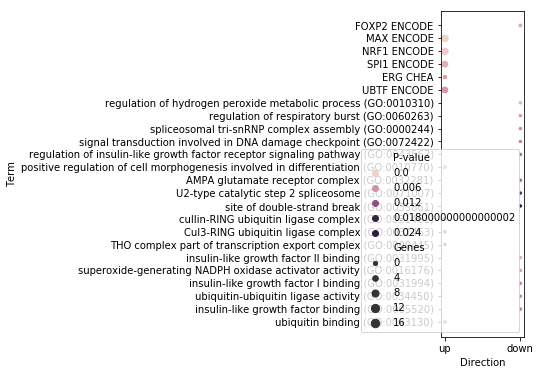

In [41]:
reactomes = list(merged_df_filtered[merged_df_filtered["Dataset"]=="Reactome"].sort_values(["P-value"]).iloc[:6]["Term"])
keggs = list(merged_df_filtered[merged_df_filtered["Dataset"]=="KEGG"].sort_values(["P-value"]).iloc[:6]["Term"])
bioplanets = list(merged_df_filtered[merged_df_filtered["Dataset"]=="BioPlanet"].sort_values(["P-value"]).iloc[:6]["Term"])
encodes = list(merged_df_filtered[merged_df_filtered["Dataset"]=="Encode/ChEA TFs"].sort_values(["P-value"]).iloc[:6]["Term"])
gobp = list(merged_df_filtered[merged_df_filtered["Dataset"]=="GO BP"].sort_values(["P-value"]).iloc[:6]["Term"])
gomf = list(merged_df_filtered[merged_df_filtered["Dataset"]=="GO MF"].sort_values(["P-value"]).iloc[:6]["Term"])
gocc = list(merged_df_filtered[merged_df_filtered["Dataset"]=="GO CC"].sort_values(["P-value"]).iloc[:6]["Term"])

rows1 = gobp + gomf + gocc + encodes
rows2 = reactomes + keggs + bioplanets

df1 = merged_df_filtered.loc[merged_df_filtered["Term"].isin(rows1),:]
df2 = merged_df_filtered.loc[merged_df_filtered["Term"].isin(rows2),:]

plt.rcParams['figure.figsize'] = [1.5, 6]

fig, ax = plt.subplots(1,1)
g = plotTableDots(df1,palette=cmap,s=30)
fig.savefig("plots/enrichr1.pdf", bbox_inches='tight')
#pflotTableDots(df2,palette=cmap)


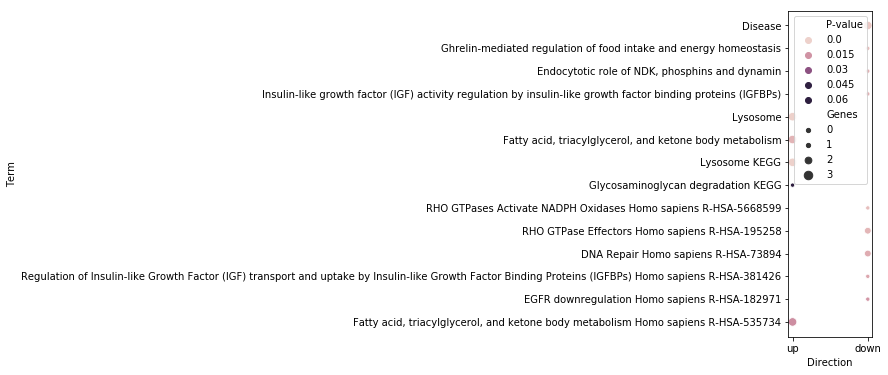

In [42]:
plt.rcParams['pdf.fonttype'] = 42
fig, ax = plt.subplots(1,1)
g = plotTableDots(df2,palette=cmap)
fig.savefig("plots/enrichr2.pdf", bbox_inches='tight')


That's it! Feel free to contact for questions, bugs, etc.

In [43]:
mnn_corrected.write("mnn_corrected.h5ad")

... storing 'Condition' as categorical
... storing 'disease' as categorical
